# Classifier Comparison on Toy Datasets

In [1]:
import xgboost
import ipyvolume as ipv

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.datasets import make_moons, make_circles, make_classification, make_swiss_roll

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
?MLPClassifier

# define classifiers

In [7]:
names = [ "Gaussian Process", "Neural Net [10,10,10 MLP] ", "XGBoost [3 x 100 rounds]" ]

classifiers = [    
    GaussianProcessClassifier(),
    MLPClassifier(hidden_layer_sizes = (10,10,10), activation = 'tanh', batch_size=64),
    xgboost.XGBClassifier(n_jobs=40)]

# KNeighborsClassifier(), SVC(), RandomForestClassifier(),

assert( len(names) == len(classifiers) )

# make datasets

In [8]:
nSamples = 5000

def dataset_3 ( nSamples ):    
    X, y = make_classification(n_samples = nSamples, n_features=2, n_redundant=0, n_informative=2,
                               random_state=1, n_clusters_per_class=1)
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    return (X, y)
    

noiseFactor = 1.5
datasets = [make_moons(n_samples = nSamples//10, noise=0.2*noiseFactor, random_state=0),
            make_circles(n_samples = nSamples//10, noise=0.1*noiseFactor, factor=0.75, random_state=1),
            dataset_3 ( nSamples//10 ),
            make_moons(n_samples = nSamples, noise=0.2*noiseFactor, random_state=0),
            make_circles(n_samples = nSamples, noise=0.1*noiseFactor, factor=0.75, random_state=1),
            #make_moons(n_samples = nSamples, noise=0.2*noiseFactor, random_state=0),
            #make_circles(n_samples = nSamples, noise=0.1*noiseFactor, factor=0.5, random_state=1),
            dataset_3 ( nSamples ),
            ]

/conda/envs/rapids/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/conda/envs/rapids/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/conda/envs/rapids/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


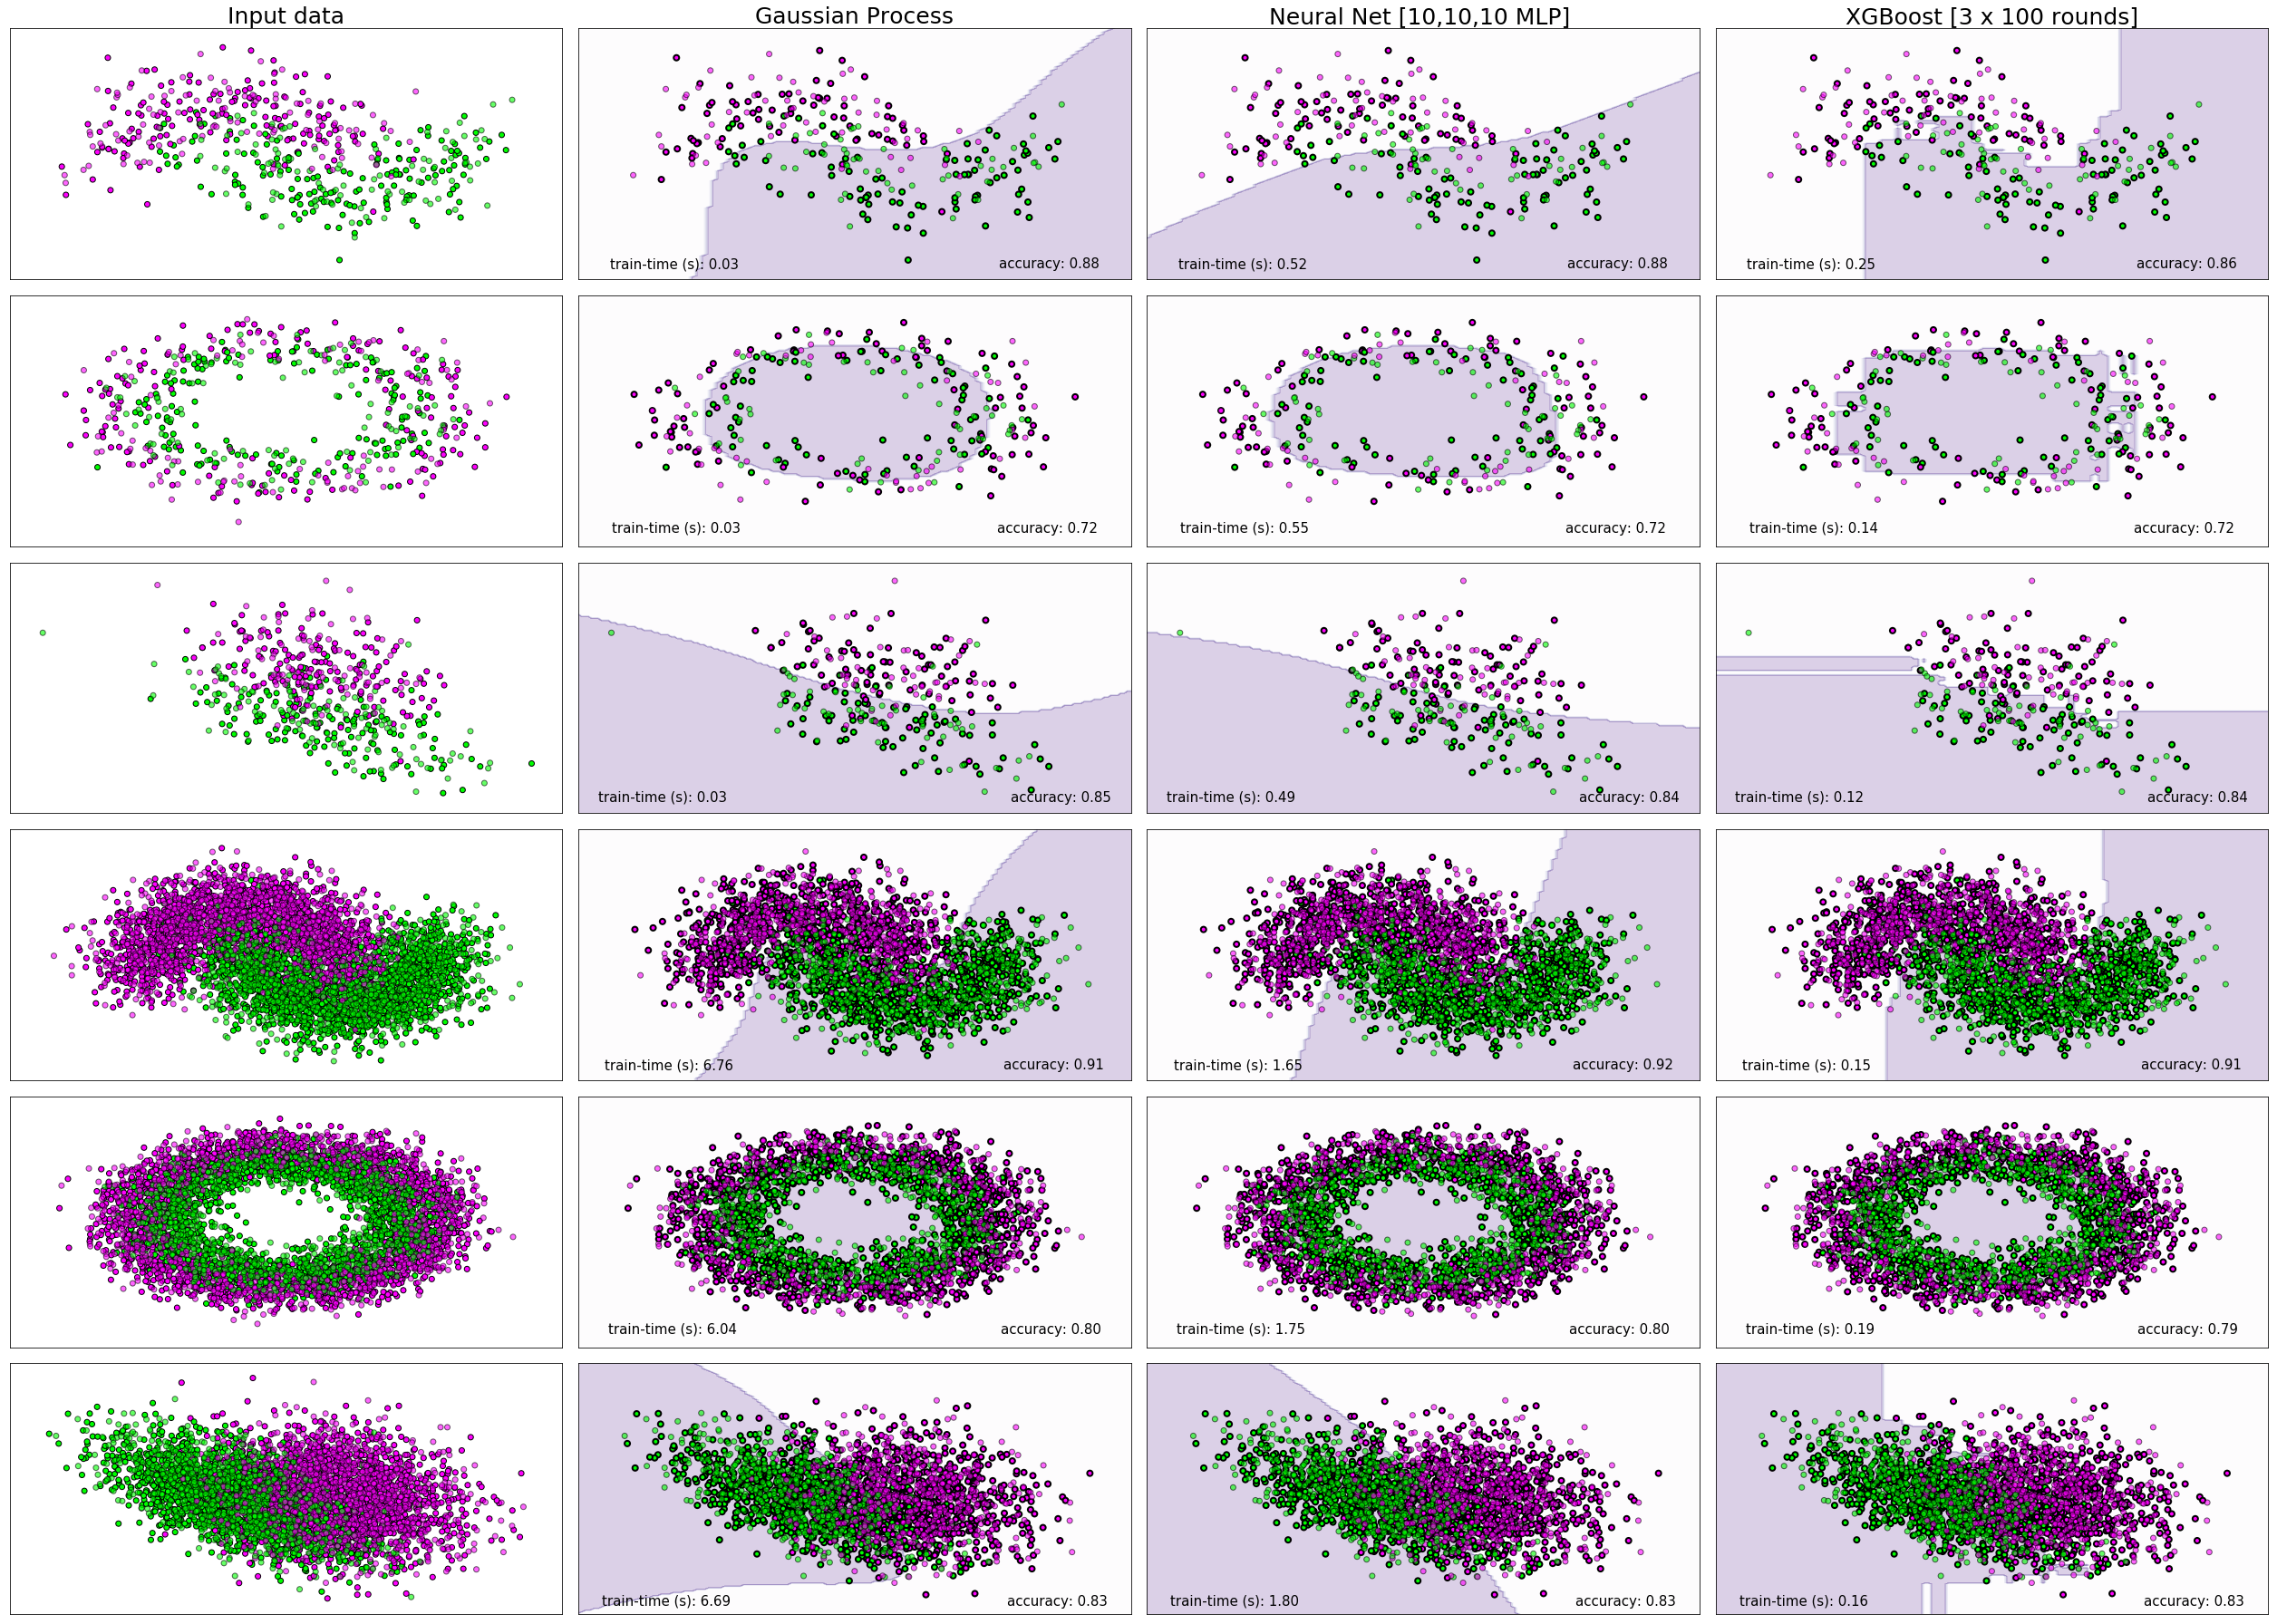

In [10]:
figure = plt.figure(figsize=(35, 25))
h = .05  # step size in the mesh
i = 1

# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)
    
    # define plotting bounds
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # plot the train & test data
    cm = plt.cm.Purples #PRGn#tab20b#spring#cool#PRGn#PiYG#PuOr#RdBu
    cm_bright = ListedColormap(['#FF00FF', '#00FF00'])
    
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0: ax.set_title("Input data", size = 25)
    
    # plot training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,edgecolors='k')
    
    # plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')
    
    # apply bounds
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        
        # train classifier
        startTime = time.time()
        clf.fit(X_train, y_train)
        trainDuration = time.time() - startTime
        
        # compute accuracy
        score = clf.score(X_test, y_test)

        # visualize the decision boundary 
        # make a prediction for every point in the meshgrid
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        elif hasattr(clf, "predict"):
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])            
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        # plot predictions
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.2)

        # plot the training points
        ax.scatter(X_train[::2, 0], X_train[::2, 1], c=y_train[::2], cmap=cm_bright, edgecolors='k', linewidths=2)        
        # plot the testing points
        ax.scatter(X_test[::2, 0], X_test[::2, 1], c=y_test[::2], cmap=cm_bright, edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max());ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(()); ax.set_yticks(())
        
        # plot title on first row
        if ds_cnt == 0: ax.set_title(name, size=25)
            
        ax.text(xx.max() - .3, yy.min() + .3, ('accuracy: %.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
        ax.text(xx.min() + .3, yy.min() + .3, ('train-time (s): %.2f' % trainDuration).lstrip('0'), size=15, horizontalalignment='left')

        i += 1

plt.tight_layout()
plt.show()